# Exploration & Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib 

In [2]:
data = pd.read_csv('../Data/paris_real_estate.csv')

D:\Bureau\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,20,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.isnull(data).sum()/len(data)*100

id_mutation                       0.000000
date_mutation                     0.000000
numero_disposition                0.000000
nature_mutation                   0.000000
valeur_fonciere                   0.332329
adresse_numero                    0.263094
adresse_suffixe                  95.657216
adresse_nom_voie                  0.257901
adresse_code_voie                 0.257901
code_postal                       0.259632
code_commune                      0.000000
nom_commune                       0.000000
code_departement                  0.000000
ancien_code_commune             100.000000
ancien_nom_commune              100.000000
id_parcelle                       0.000000
ancien_id_parcelle              100.000000
numero_volume                    99.498044
lot1_numero                      11.044761
lot1_surface_carrez              57.389137
lot2_numero                      64.811161
lot2_surface_carrez              88.986395
lot3_numero                      93.839790
lot3_surfac

Keep only var 

In [4]:
var_tokeep = ['valeur_fonciere', 'code_postal', 'id_parcelle', 'nombre_pieces_principales', 'surface_reelle_bati']

In [5]:
data = data[var_tokeep]

dropna

In [6]:
data.dropna(inplace=True)

Identify outliers

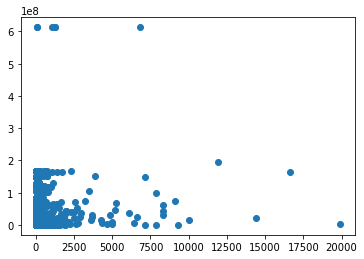

In [7]:
plt.scatter(data['surface_reelle_bati'], data['valeur_fonciere'])
plt.show()

In [8]:
data['ratio_size_price'] = data['valeur_fonciere'] / data['surface_reelle_bati']

Clean outliers

In [9]:
cleaned_data = data[
                  (data['ratio_size_price'] < data['ratio_size_price'].quantile(0.80)) &
                  (data['ratio_size_price'] > data['ratio_size_price'].quantile(0.10)) &
                  (data['surface_reelle_bati'] < data['surface_reelle_bati'].quantile(0.95)) &
                  (data['valeur_fonciere'] < data['valeur_fonciere'].quantile(0.85)) &
                  (data['valeur_fonciere'] > data['valeur_fonciere'].quantile(0.05))
                ]
cleaned_data = cleaned_data.drop('ratio_size_price', axis=1)

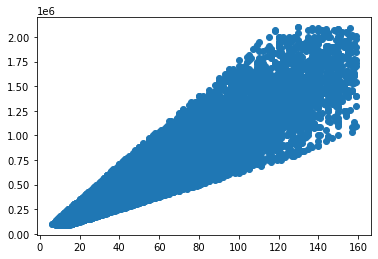

In [10]:
plt.scatter(cleaned_data['surface_reelle_bati'], cleaned_data['valeur_fonciere'])
plt.show()

# Feature engineering

In [11]:
aggregated_data = cleaned_data.copy()

## One hot encoding

### Parcelle

In [12]:
aggregated_data['plot'] = aggregated_data.apply(lambda x: re.findall(r'\D+', x['id_parcelle'])[0], axis=1)
aggregated_data.drop(['id_parcelle'], axis=1, inplace=True)

In [13]:
plots = aggregated_data['plot'].unique()
ohe_plots = OneHotEncoder(handle_unknown='ignore', sparse=False, )
ohe_plots.fit(aggregated_data[['plot']])
df_plots = pd.DataFrame(ohe_plots.transform(aggregated_data[['plot']]), columns = plots)
aggregated_data.drop(['plot'], axis=1, inplace=True)

In [14]:
aggregated_data

valeur_fonciere  code_postal  nombre_pieces_principales  \
0            1196000.0      75001.0                        3.0   
1            1570490.0      75003.0                        3.0   
5             230000.0      75003.0                        1.0   
7             955750.0      75008.0                        3.0   
8             506800.0      75003.0                        2.0   
...                ...          ...                        ...   
57720         852400.0      75004.0                        2.0   
57748         680000.0      75002.0                        3.0   
57771         610000.0      75004.0                        2.0   
57772        1400000.0      75002.0                        0.0   
57773        1400000.0      75002.0                        3.0   

       surface_reelle_bati  
0                    112.0  
1                    104.0  
5                     26.0  
7                     80.0  
8                     45.0  
...                    ...  
57720                 67.0  
57748                 72.0  
57771                 44.0  
57772                100.0  
57773                 97.0  

[28151 rows x 4 columns]

### Postal codes

In [15]:
aggregated_data['code_postal'] = aggregated_data['code_postal'].astype('str')
postal_codes = aggregated_data['code_postal'].unique()
ohe_postal_codes = OneHotEncoder(handle_unknown='ignore', sparse=False, )
ohe_postal_codes.fit(aggregated_data[['code_postal']])
df_postal_codes = pd.DataFrame(ohe_postal_codes.transform(aggregated_data[['code_postal']]), columns = postal_codes)
aggregated_data.drop(['code_postal'], axis=1, inplace=True)

In [16]:
aggregated_data = pd.merge(aggregated_data, pd.merge(df_plots, df_postal_codes, left_index = True, right_index = True), left_index = True, right_index = True)

## Normalize

### Number of rooms and size

In [17]:
to_normalize = ['nombre_pieces_principales', 'surface_reelle_bati']

In [18]:
scaler = MinMaxScaler()
aggregated_data[to_normalize] = scaler.fit_transform(aggregated_data[to_normalize])

In [19]:
aggregated_data

valeur_fonciere  nombre_pieces_principales  surface_reelle_bati   BC  \
0            1196000.0                   0.272727             0.690789  0.0   
1            1570490.0                   0.272727             0.638158  0.0   
5             230000.0                   0.090909             0.125000  0.0   
7             955750.0                   0.272727             0.480263  0.0   
8             506800.0                   0.181818             0.250000  0.0   
...                ...                        ...                  ...  ...   
28139         420000.0                   0.000000             0.263158  0.0   
28142         175000.0                   0.090909             0.026316  0.0   
28146         985000.0                   0.363636             0.585526  0.0   
28148         274000.0                   0.000000             0.164474  0.0   
28150         307000.0                   0.090909             0.125000  0.0   

        AL   AB   CG   AG   BF   AV  ...  75013.0  75014.0  75015.0  75016.0  \
0      0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
7      0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
8      0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
...    ...  ...  ...  ...  ...  ...  ...      ...      ...      ...      ...   
28139  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
28142  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
28146  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
28148  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   
28150  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0      0.0      0.0      0.0   

       75017.0  75018.0  75020.0  75019.0  75004.0  75002.0  
0          0.0      0.0      0.0      0.0      0.0      0.0  
1          0.0      0.0      0.0      0.0      0.0      0.0  
5          0.0      0.0      0.0      0.0      0.0      0.0  
7          0.0      0.0      0.0      0.0      0.0      0.0  
8          0.0      0.0      0.0      0.0      0.0      0.0  
...        ...      ...      ...      ...      ...      ...  
28139      0.0      0.0      0.0      0.0      0.0      0.0  
28142      0.0      0.0      0.0      0.0      0.0      0.0  
28146      0.0      0.0      0.0      0.0      0.0      0.0  
28148      0.0      0.0      0.0      0.0      0.0      0.0  
28150      0.0      0.0      0.0      0.0      0.0      0.0  

[13502 rows x 181 columns]

# Model

In [20]:
rf = RandomForestRegressor(random_state = 42)

In [21]:
y = aggregated_data[['valeur_fonciere']]
X = aggregated_data.drop('valeur_fonciere', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
rf.fit(X_train, y_train)

<ipython-input-22-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [23]:
rf.score(X_test, y_test)

0.8672823802057632

Train three models -> grid search -> Stacking

# Saves Files

In [24]:
joblib.dump(rf, '../model/re_prediction_model.pkl')
joblib.dump(scaler, '../model/re_scaler.pkl')
joblib.dump(ohe_plots, '../model/re_ohe_plots.pkl')
joblib.dump(ohe_postal_codes, '../model/re_ohe_postal_codes.pkl')

['../model/re_ohe_postal_codes.pkl']